# Evaluation of GPT-2 models with FHE-compliant operators 

This notebook presents a first approach of how to execute a GPT model in FHE, where some specific parts of the model are converted to FHE computations.
The following considers the GPT-2 model with the language modeling head on top, with the following configuration: 12 layers, 12 attention heads, 768 embedding dimensions and a vocabulary size of 50257 words.
Additionally, the QGPT-2 models are built around Hugging Face's Transformer library, sharing the same API with only a few additional steps to acknowledge.

The performance of two quantized versions of the GPT-2 model:
- a model that quantizes a single attention head found in the first layer: SingleHeadQGPT2Model
- a model that quantizes a complete multi-head attention pass found in the first layer: MultiHeadsQGPT2Model

The quantized operators from these models are FHE-compliant, meaning that these specific part can be executed in FHE, while the rest of the model are done in float in the clear.
This notebook explains how to load these models from the Hugging Face's associated pre-trained ones, calibrate them, compile their FHE circuit and then execute their inference with some FHE.
Finally, different top-k accuracies on the next token predicted from a base text for both models with respect to the number of bits of quantization used are compared. Using these figures, the notebook shows that inputs and weights can be quantized over less than 8 bits to make the inference reach near-floating point performances.


### Imports and loads

In [1]:
import logging
import time

import matplotlib.pyplot as plt
import torch
from load_huggingface import get_gpt2_model, get_gpt2_tokenizer
from qgpt2_models import MultiHeadsQGPT2Model, SingleHeadQGPT2Model

# Disable some warnings from Hugging Face when loading the models
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

Load the GPT-2 model (GPT2LMHeadModel) and tokenizer.

In [2]:
gpt2_model = get_gpt2_model("gpt2_model")
gpt2_tokenizer = get_gpt2_tokenizer("gpt2_tokenizer")

### Example with Hugging Face

First, a simple example using a short sequence is shown, generating a few tokens with Hugging Face's GPT-2 model.

In [3]:
input_sentence = "Computations on encrypted data can help"

Now encode the sequence using the tokenizer and retrieve the input token ids.

In [4]:
input_token_indexes = gpt2_tokenizer.encode(input_sentence)
input_ids = torch.tensor(input_token_indexes).unsqueeze(0)

Finally, generate 10 new tokens and decode the output sentence. 

In [5]:
output_ids = gpt2_model.generate(input_ids, max_new_tokens=4, use_cache=False)
gpt2_tokenizer.decode(output_ids[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Computations on encrypted data can help protect your privacy.'

## Single Attention Head Model

Here, the model's first attention head of its first layer, as well as its associated first projection, is done using quantized operators. 
The rest remains the same as in Hugging Face's implementation. Mode details can be found in SingleHeadQGPT2Model's documentation.

First, load the model using the pre-trained files. 
Only 7 bits of quantization is needed in order to recover the same sentence as with the initial floating point model.

In [6]:
proj_single_head_qgpt2 = SingleHeadQGPT2Model.from_pretrained(
    "gpt2_model", n_bits=7, use_cache=False
)

Then generate the next 10 tokens in the clear with the quantized operators in order to retrieve the sentence. 

In [7]:
proj_single_head_qgpt2.set_fhe_mode(fhe="disable")

output_ids_clear = proj_single_head_qgpt2.generate(input_ids, max_new_tokens=4)
gpt2_tokenizer.decode(output_ids_clear[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Computations on encrypted data can help protect your privacy.'

The generated sentence exactly matches the one from Hugging Face original model.

The logits for the next predicted token are now generated in the clear.

In [8]:
proj_single_head_qgpt2.set_fhe_mode(fhe="disable")

output_logits_clear = proj_single_head_qgpt2(input_ids).logits

The model is compiled using the input token ids.
Here, the model executes the forward pass in the clear, which computes and stores the necessary quantization parameters.
Once this is done, a FHE circuit is built, which then can be used to execute the forward pass with its quantized parts done in FHE.

In [12]:
circuit_single_head = proj_single_head_qgpt2.compile(input_ids, msbs_round=6)

Circuit compiled with at most 15 bits


The circuit's bit-width reaches 15 bits at most.

The model is set in simulation mode in order to retrieve the logits that are expected to be computed with FHE.

In [13]:
proj_single_head_qgpt2.set_fhe_mode(fhe="simulate")

output_logits_simulated = proj_single_head_qgpt2(input_ids).logits

The single head attention is now ready for execution in FHE.

In [14]:
proj_single_head_qgpt2.set_fhe_mode(fhe="execute")

start = time.time()
output_logits_fhe = proj_single_head_qgpt2(input_ids).logits
end = time.time()
execution_time = end - start

print(f"Time taken to execute the single head in FHE: {execution_time:.2f} seconds")

Time taken to execute the single head in FHE: 166.38 seconds


## Multi-Head Attention Model

Here, the model's multi-head attention found in its first layer is done using quantized operators.
The rest remains the same as in Hugging Face's implementation. More details can be found in MultiHeadsQGPT2Model's documentation.

The model is loaded using the pre-trained files.
In this case, 10 bits of quantization are needed in order to recover almost the same sentence as with the initial floating point model.

In [16]:
proj_12_heads_qgpt2 = MultiHeadsQGPT2Model.from_pretrained("gpt2_model", n_bits=10, use_cache=False)

Similarly, new tokens are generated in the clear and the output sentence is decoded.

In [17]:
proj_12_heads_qgpt2.set_fhe_mode(fhe="disable")

output_ids_clear = proj_12_heads_qgpt2.generate(input_ids, max_new_tokens=4)
gpt2_tokenizer.decode(output_ids_clear[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Computations on encrypted data can help protect your privacy.'

The generated sentence matches the one from Hugging Face's original model. However, in its current form, the MHA part requires less precision to run on encrypted data. The precision can be reduced to 7 bits for this operation.

In [18]:
proj_12_heads_qgpt2 = MultiHeadsQGPT2Model.from_pretrained("gpt2_model", n_bits=7, use_cache=False)
proj_12_heads_qgpt2.set_fhe_mode(fhe="disable")

output_ids_clear = proj_12_heads_qgpt2.generate(input_ids, max_new_tokens=4)
gpt2_tokenizer.decode(output_ids_clear[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Computations on encrypted data can help protect your data from'

The meaning of the generated sentence is close to the original, and the compilation to FHE can now be checked.

The logits for the next predicted token are generated in the clear, and then the model is compiled in the same way.

In [19]:
proj_12_heads_qgpt2.set_fhe_mode(fhe="disable")

output_logits_clear = proj_12_heads_qgpt2(input_ids).logits

In [20]:
circuit_12_heads = proj_12_heads_qgpt2.compile(input_ids, msbs_round=6)

Circuit compiled with at most 15 bits


In this case, the circuit reaches 15 bits of precision.

The model is then executed with simulation, and it is observed that the same outputs as those computed in the clear with quantized operators are retrieved.

In [21]:
proj_12_heads_qgpt2.set_fhe_mode(fhe="simulate")

output_logits_simulated = proj_12_heads_qgpt2(input_ids).logits

The multi-head attention is now ready for execution in FHE.

In [22]:
proj_12_heads_qgpt2.set_fhe_mode(fhe="execute")

start = time.time()
output_logits_fhe = proj_12_heads_qgpt2(input_ids).logits
end = time.time()

execution_time = end - start
print(f"Time taken to execute the multi-head in FHE: {execution_time:.2f} seconds")

Time taken to execute the multi-head in FHE: 862.97 seconds


## Performance Evaluation

In the following, the impact of the number of bits used for quantization on the models' performance is evaluated.
Top-k accuracies are checked, with a few different values of k, on the predicted next logits with respect to the one computed by the initial floating point model.

Model: SingleHeadQGPT2Model, n_bits: 2, Average Top-1 Accuracy: 0.7217
Model: SingleHeadQGPT2Model, n_bits: 3, Average Top-1 Accuracy: 0.7217
Model: SingleHeadQGPT2Model, n_bits: 4, Average Top-1 Accuracy: 0.9586
Model: SingleHeadQGPT2Model, n_bits: 5, Average Top-1 Accuracy: 0.9561
Model: SingleHeadQGPT2Model, n_bits: 6, Average Top-1 Accuracy: 0.9783
Model: SingleHeadQGPT2Model, n_bits: 7, Average Top-1 Accuracy: 0.9854
Model: SingleHeadQGPT2Model, n_bits: 8, Average Top-1 Accuracy: 0.9949
Model: SingleHeadQGPT2Model, n_bits: 9, Average Top-1 Accuracy: 0.9981
Model: SingleHeadQGPT2Model, n_bits: 10, Average Top-1 Accuracy: 0.9968
Model: SingleHeadQGPT2Model, n_bits: 11, Average Top-1 Accuracy: 0.9975
Model: SingleHeadQGPT2Model, n_bits: 2, Average Top-5 Accuracy: 0.9153
Model: SingleHeadQGPT2Model, n_bits: 3, Average Top-5 Accuracy: 0.9153
Model: SingleHeadQGPT2Model, n_bits: 4, Average Top-5 Accuracy: 0.9987
Model: SingleHeadQGPT2Model, n_bits: 5, Average Top-5 Accuracy: 0.9994
Mode

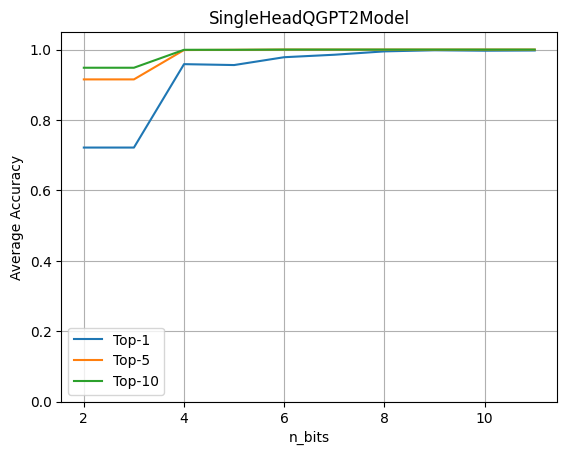

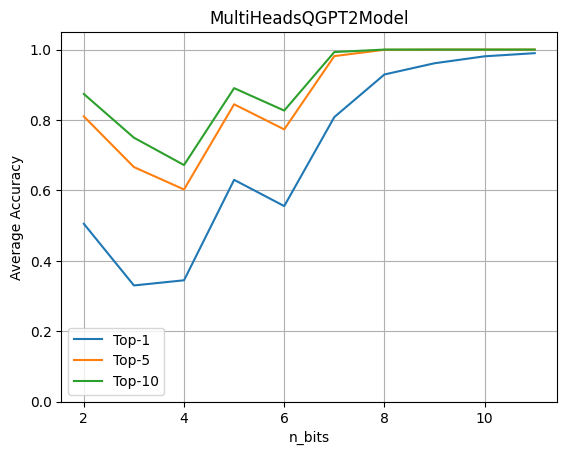

In [24]:
%matplotlib inline


def generate_topk_tokens(model, tokenizer, text, top_k):
    """Generate the top-k tokens for every token in the text."""
    inputs = tokenizer.encode(text, return_tensors="pt")
    topk_tokens_list = []
    with torch.no_grad():
        outputs = model(inputs)
        logits = outputs.logits
        for logit in logits[0]:
            topk_tokens = torch.topk(
                logit,
                top_k,
            ).indices.tolist()
            topk_tokens_list.append(topk_tokens)
    return topk_tokens_list


def calculate_topk_accuracy(ground_truth_tokens, computed_tokens):
    """Calculate the top-k accuracy."""
    correct_count = sum([1 for gt_token in ground_truth_tokens if gt_token in computed_tokens])
    return correct_count / len(ground_truth_tokens)


# Define the models to evaluate
models = {
    "SingleHeadQGPT2Model": SingleHeadQGPT2Model,
    "MultiHeadsQGPT2Model": MultiHeadsQGPT2Model,
}

# Define the different number of bits and k values to evaluate
n_bits_range = list(range(2, 12))
top_ks = [1, 5, 10]

# Define the text data to use for the evaluation
dataset_file = "data.txt"

# Read the evaluation file
with open(dataset_file, "r", encoding="utf-8") as file:
    input_texts = [line.strip() for line in file]

for model_name, Model in models.items():
    plt.figure()
    for top_k in top_ks:
        accuracies = []
        for n_bits in n_bits_range:

            # Load the model using the current number of bits and set it to clear quantized mode
            model = Model.from_pretrained(
                "gpt2_model",
                n_bits=n_bits,
            )
            model.set_fhe_mode(fhe="disable", true_float=False)

            accuracy_scores = []
            for text in input_texts:
                # Generate the top-k tokens for the Hugging Face floating point model
                hf_topk_tokens_list = generate_topk_tokens(gpt2_model, gpt2_tokenizer, text, 1)

                # Generate the top-k tokens for the quantized model
                clone_topk_tokens_list = generate_topk_tokens(model, gpt2_tokenizer, text, top_k)

                # Compute the top-k accuracy for each token in the text
                for hf_topk_tokens, clone_topk_tokens in zip(
                    hf_topk_tokens_list, clone_topk_tokens_list
                ):
                    topk_accuracy = calculate_topk_accuracy(hf_topk_tokens, clone_topk_tokens)
                    accuracy_scores.append(topk_accuracy)

            # Compute the average accuracy within the text
            average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
            accuracies.append(average_accuracy)

            # Print the average accuracy for this model, n_bits, and top_k
            print(
                f"Model: {model_name}, "
                f"n_bits: {n_bits}, "
                f"Average Top-{top_k} Accuracy: {average_accuracy:.4f}"
            )

        plt.plot(n_bits_range, accuracies, label=f"Top-{top_k}")

    # Plot the model's evaluation
    plt.title(f"{model_name}")
    plt.xlabel("n_bits")
    plt.ylabel("Average Accuracy")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)

plt.show()

The results show that for the first model, where only a single head is done with FHE-compliant operators, 4 bits are enough to recover 95% of Hugging Face's performance in terms of top-1 accuracy.
For the second model, which implements a complete multi-head attention with quantized operators, 7 bits gives a 80% exact predictions while the top-5 and top-10 accuracies reach 98%.